In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from scipy.stats import norm
import tensorflow as tf
import time as ttt
import iisignature as iisig
from tqdm import *
import pickle
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.optimizers import Adam
from keras.regularizers import L1L2

C:\Users\zhaoy\.conda\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# should be '1.10.0'
tf.__version__

'1.10.0'

In [3]:
sess = tf.InteractiveSession()
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [4]:
steps = 5000
segs = 20 # number of segmentsW

W_segs = np.load("W_{}_from_{}.npy".format(segs, steps))
sig = np.load("sig_{}_from_{}.npy".format(segs, steps))
Paths = np.load("Paths_{}.npy".format(steps))
n_paths = W_segs.shape[0]

In [5]:
x0 = 1.0 # initial condition
sigma = 1 # volatility
mu = 0.02
r = 0.01 # risk free rate
batch_size = 1000 # batch size
T = 1 # maturity
dt = T/steps # mesh size
true = 0.5828174603130847# true option price

dt = T/steps # mesh size
dt_new = T/segs # new mesh after shrinkage
level = 3 # truncation level
sig_dim = iisig.siglength(2,level)# dimension of siganature

In [6]:
def generate_t(T, batch_size = batch_size):
    '''
    generate time steps
    dim = batch_size * (steps+1). eg. 2000 * 101
    '''
    return np.tile(np.linspace(1e-8, T+1e-8, segs + 1, dtype = np.float32), (batch_size,1))

In [7]:
t = generate_t(T, segs)[0][0:]
len(t)

6

In [8]:
# place holders
signature = tf.placeholder(dtype=tf.float32, shape=[batch_size,  segs+1, sig_dim])
BM = tf.placeholder(dtype=tf.float32, shape=[batch_size, segs+1])
terminal = tf.placeholder(dtype=tf.float32, shape=[batch_size,1])

In [9]:
def true_solution(apath):
    '''
    Explicit solution of lookback option.
    '''
    steps = apath.shape[0]-1
    dt = T/steps
    t = np.linspace(0, T, steps+1)
    
    inf_apath = [min(apath[:i]) for i in range(1, steps+2)]
    true_solution = []
    
    for i in range(steps+1):
        a_1 = ( np.log(apath[i] / inf_apath[i]) + (r + sigma**2/2)*(T - t[i]) ) / (sigma * np.sqrt(T - t[i]))
        a_2 = a_1 - (sigma * np.sqrt(T - t[i]))
        a_3 = a_1 - 2*r/sigma*np.sqrt(T - t[i])
        true_solution.append(apath[i] * norm.cdf(a_1) - inf_apath[i] * np.exp(-r * (T - t[i])) * norm.cdf(a_2)
                            - apath[i] * sigma**2 / (2*r) * (norm.cdf(-a_1) - np.exp(-r * (T - t[i])) * (inf_apath[i]/apath[i])**(2*r/sigma**2) * norm.cdf(-a_3))
                            )
    
    return true_solution

In [10]:
true_solution(Paths[1])[0]

C:\Users\zhaoy\.conda\envs\py35\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


0.5828174623020916

In [11]:
def terminal_condition(paths):
    '''
    Terminal condition of a lookback option
    '''
    return paths[:, None, -1] - np.min(paths, axis=1, keepdims=True)

In [12]:
terminal_data = np.reshape(terminal_condition(Paths), (n_paths, 1))

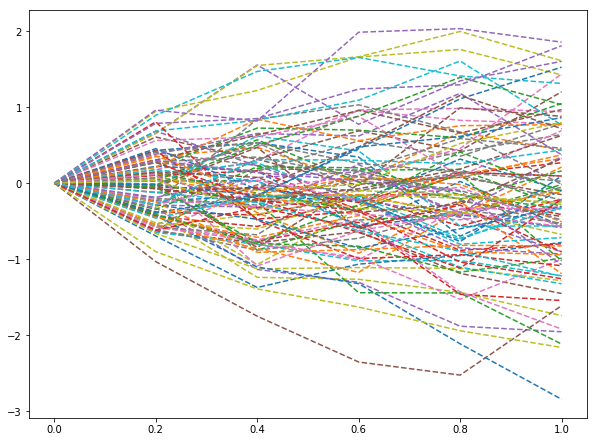

In [13]:
plt.figure(figsize=(10,7.5))
for i in range(100):
    plt.plot(np.linspace(0, T, segs+1), W_segs[i], "--")

In [14]:
# Y_0 random initialization
Y0 = tf.Variable(tf.random_uniform([batch_size, 1],dtype =tf.float32)) 
# number of lstm unit
n_a = 128
LSTM_cell = LSTM(n_a, return_state = True)
Z_densor = Dense(1) #from output of LSTM to a number

In [15]:
def loss_function(signature, BM, terminal): 
    
    #Time 0:
    a = tf.Variable(tf.zeros([batch_size, n_a]), trainable=False)
    c = tf.Variable(tf.zeros([batch_size, n_a]), trainable=False)
    
    input_s = K.slice(signature, [0,0,0], [batch_size, 1, sig_dim])
    a, _, c = LSTM_cell(input_s, initial_state = [a, c])
    Z = Z_densor(a)
    Y = Y0
    all_Y = Y
    all_Z = Z

    ############################################################################# 
    for i in range(segs):
        # Euler scheme update $Y$
        dW = K.slice(BM, [0, i+1], [batch_size, 1]) - K.slice(BM, [0,i], [batch_size,1])
        Y = Y + r*Y * dt_new + Z * dW
        
        input_s = K.slice(signature, [0, i+1, 0], [batch_size,1, sig_dim])
        a, _, c = LSTM_cell(input_s, initial_state = [a, c])
        Z = Z_densor(a)
        all_Y = K.concatenate([all_Y, Y])
        all_Z = K.concatenate([all_Z, Z]) 
    loss = tf.reduce_sum(tf.square(Y - terminal))
    
    return loss/batch_size, all_Y, all_Z

In [16]:
Epoch =  5000+1

In [17]:
loss, all_Y, all_Z = loss_function( signature, BM, terminal)

In [18]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.Variable(0.001, trainable=False)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, clip_norm=8.0)
train_op = optimizer.minimize(loss, global_step=global_step)

In [19]:
init = tf.global_variables_initializer()
sess.run(init)

In [20]:
# log_signature_test = logsig_sig[:batch_size]
# log_signature_feed = logsig_sig[batch_size:]

signature_test = sig[:batch_size]
signature_feed = sig[batch_size:]

W_segs_test = W_segs[:batch_size]
W_segs_feed = W_segs[batch_size:]

terminal_test = terminal_data[:batch_size]
terminal_feed = terminal_data[batch_size:]

path_test = Paths[:batch_size]
# path_feed = Paths[batch_size:]

# time_feed = generate_t(T, batch_size)
test_dict = {signature: signature_test, BM: W_segs_test, terminal: terminal_test}

train_loss_list = []
test_loss_list = []
Y0_list = []

1th Iteration:
Y0 is 0.5582453012466431, and true option price is 0.5828174603130847.
traing loss is 0.1320214718580246, test loss is 0.12069384008646011.
learning rate is 0.0010000000474974513, elapsed is 0.015955448150634766.
 


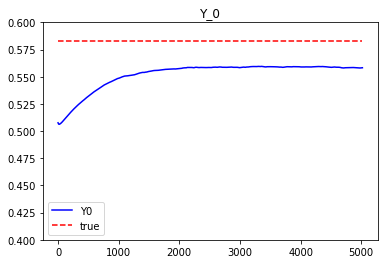

11th Iteration:
Y0 is 0.5582594871520996, and true option price is 0.5828174603130847.
traing loss is 0.19011753797531128, test loss is 0.12851691246032715.
learning rate is 0.0010000000474974513, elapsed is 0.18613505363464355.
 
21th Iteration:
Y0 is 0.5582088828086853, and true option price is 0.5828174603130847.
traing loss is 0.17663678526878357, test loss is 0.13129734992980957.
learning rate is 0.0010000000474974513, elapsed is 0.11008501052856445.
 
31th Iteration:
Y0 is 0.5581629276275635, and true option price is 0.5828174603130847.
traing loss is 0.22544273734092712, test loss is 0.12864375114440918.
learning rate is 0.0010000000474974513, elapsed is 0.10471916198730469.
 
41th Iteration:
Y0 is 0.5581663250923157, and true option price is 0.5828174603130847.
traing loss is 0.13728845119476318, test loss is 0.13094472885131836.
learning rate is 0.0010000000474974513, elapsed is 0.0983119010925293.
 
51th Iteration:
Y0 is 0.5581971406936646, and true option price is 0.58281746

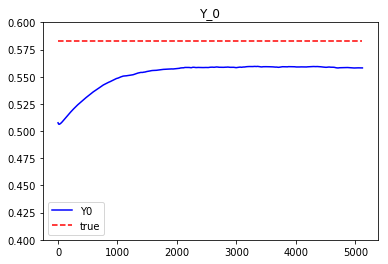

111th Iteration:
Y0 is 0.5581905245780945, and true option price is 0.5828174603130847.
traing loss is 0.22310660779476166, test loss is 0.12940843403339386.
learning rate is 0.0010000000474974513, elapsed is 0.17461061477661133.
 
121th Iteration:
Y0 is 0.5582916140556335, and true option price is 0.5828174603130847.
traing loss is 0.14404048025608063, test loss is 0.12822721898555756.
learning rate is 0.0010000000474974513, elapsed is 0.10729765892028809.
 
131th Iteration:
Y0 is 0.5583723187446594, and true option price is 0.5828174603130847.
traing loss is 0.1621951162815094, test loss is 0.125600665807724.
learning rate is 0.0010000000474974513, elapsed is 0.10871005058288574.
 
141th Iteration:
Y0 is 0.5584337115287781, and true option price is 0.5828174603130847.
traing loss is 0.1612291932106018, test loss is 0.11584034562110901.
learning rate is 0.0010000000474974513, elapsed is 0.10304903984069824.
 
151th Iteration:
Y0 is 0.5584272146224976, and true option price is 0.582817

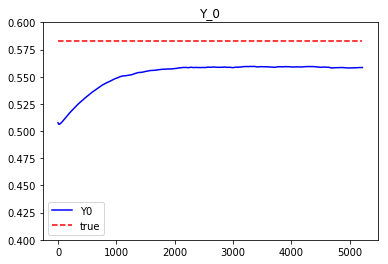

211th Iteration:
Y0 is 0.5584495663642883, and true option price is 0.5828174603130847.
traing loss is 0.20732645690441132, test loss is 0.11849482357501984.
learning rate is 0.0010000000474974513, elapsed is 0.1735367774963379.
 
221th Iteration:
Y0 is 0.5583897233009338, and true option price is 0.5828174603130847.
traing loss is 0.1370173990726471, test loss is 0.11858909577131271.
learning rate is 0.0010000000474974513, elapsed is 0.10201454162597656.
 
231th Iteration:
Y0 is 0.5583099126815796, and true option price is 0.5828174603130847.
traing loss is 0.12560513615608215, test loss is 0.11966140568256378.
learning rate is 0.0010000000474974513, elapsed is 0.1027066707611084.
 
241th Iteration:
Y0 is 0.5582331418991089, and true option price is 0.5828174603130847.
traing loss is 0.1603173166513443, test loss is 0.12140603363513947.
learning rate is 0.0010000000474974513, elapsed is 0.10617709159851074.
 
251th Iteration:
Y0 is 0.5582396388053894, and true option price is 0.582817

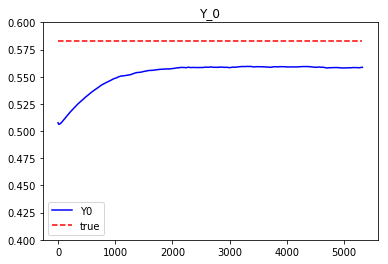

311th Iteration:
Y0 is 0.5588087439537048, and true option price is 0.5828174603130847.
traing loss is 0.1635262668132782, test loss is 0.11879148334264755.
learning rate is 0.0010000000474974513, elapsed is 0.1776256561279297.
 
321th Iteration:
Y0 is 0.5588119029998779, and true option price is 0.5828174603130847.
traing loss is 0.13368286192417145, test loss is 0.11662299931049347.
learning rate is 0.0010000000474974513, elapsed is 0.10616493225097656.
 
331th Iteration:
Y0 is 0.5588456988334656, and true option price is 0.5828174603130847.
traing loss is 0.14738281071186066, test loss is 0.11587841063737869.
learning rate is 0.0010000000474974513, elapsed is 0.10397219657897949.
 
341th Iteration:
Y0 is 0.5587494969367981, and true option price is 0.5828174603130847.
traing loss is 0.15854279696941376, test loss is 0.11556226760149002.
learning rate is 0.0010000000474974513, elapsed is 0.10206246376037598.
 
351th Iteration:
Y0 is 0.5586923956871033, and true option price is 0.5828

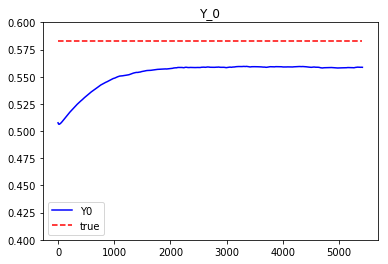

411th Iteration:
Y0 is 0.5586367249488831, and true option price is 0.5828174603130847.
traing loss is 0.1694851964712143, test loss is 0.11885279417037964.
learning rate is 0.0010000000474974513, elapsed is 0.17294096946716309.
 
421th Iteration:
Y0 is 0.5586429834365845, and true option price is 0.5828174603130847.
traing loss is 0.15992078185081482, test loss is 0.11864753812551498.
learning rate is 0.0010000000474974513, elapsed is 0.10649347305297852.
 
431th Iteration:
Y0 is 0.5586375594139099, and true option price is 0.5828174603130847.
traing loss is 0.16116087138652802, test loss is 0.118524931371212.
learning rate is 0.0010000000474974513, elapsed is 0.10837411880493164.
 
441th Iteration:
Y0 is 0.5585606694221497, and true option price is 0.5828174603130847.
traing loss is 0.15888093411922455, test loss is 0.12001147866249084.
learning rate is 0.0010000000474974513, elapsed is 0.10740280151367188.
 
451th Iteration:
Y0 is 0.5585236549377441, and true option price is 0.58281

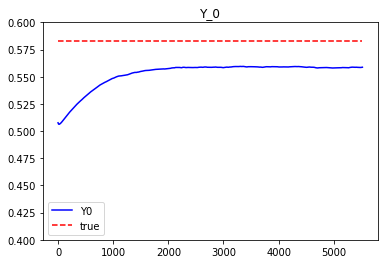

511th Iteration:
Y0 is 0.5588158369064331, and true option price is 0.5828174603130847.
traing loss is 0.16195040941238403, test loss is 0.12246880680322647.
learning rate is 0.0010000000474974513, elapsed is 0.17497777938842773.
 
521th Iteration:
Y0 is 0.5588253736495972, and true option price is 0.5828174603130847.
traing loss is 0.1554143875837326, test loss is 0.12251978367567062.
learning rate is 0.0010000000474974513, elapsed is 0.09882783889770508.
 
531th Iteration:
Y0 is 0.5588177442550659, and true option price is 0.5828174603130847.
traing loss is 0.22455045580863953, test loss is 0.12023686617612839.
learning rate is 0.0010000000474974513, elapsed is 0.10545659065246582.
 
541th Iteration:
Y0 is 0.5587003231048584, and true option price is 0.5828174603130847.
traing loss is 0.12152298539876938, test loss is 0.11813655495643616.
learning rate is 0.0010000000474974513, elapsed is 0.09967613220214844.
 
551th Iteration:
Y0 is 0.558717668056488, and true option price is 0.5828

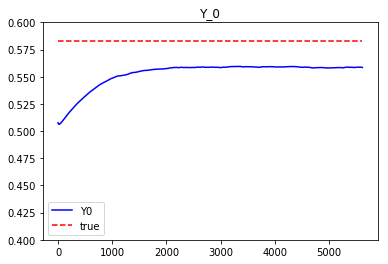

611th Iteration:
Y0 is 0.5584261417388916, and true option price is 0.5828174603130847.
traing loss is 0.15278086066246033, test loss is 0.11825129389762878.
learning rate is 0.0010000000474974513, elapsed is 0.17508935928344727.
 
621th Iteration:
Y0 is 0.5583432912826538, and true option price is 0.5828174603130847.
traing loss is 0.13390925526618958, test loss is 0.12038010358810425.
learning rate is 0.0010000000474974513, elapsed is 0.10175585746765137.
 
631th Iteration:
Y0 is 0.5583140850067139, and true option price is 0.5828174603130847.
traing loss is 0.18459448218345642, test loss is 0.12372010946273804.
learning rate is 0.0010000000474974513, elapsed is 0.10047769546508789.
 
641th Iteration:
Y0 is 0.5582866072654724, and true option price is 0.5828174603130847.
traing loss is 0.23385319113731384, test loss is 0.12258549779653549.
learning rate is 0.0010000000474974513, elapsed is 0.0995938777923584.
 
651th Iteration:
Y0 is 0.5582897663116455, and true option price is 0.582

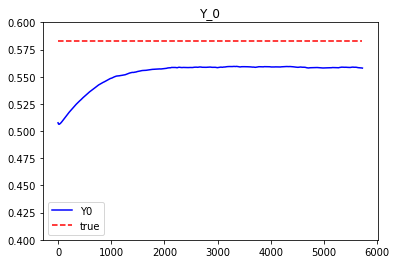

711th Iteration:
Y0 is 0.5579294562339783, and true option price is 0.5828174603130847.
traing loss is 0.23167337477207184, test loss is 0.12376713752746582.
learning rate is 0.0010000000474974513, elapsed is 0.17737674713134766.
 
721th Iteration:
Y0 is 0.5579168200492859, and true option price is 0.5828174603130847.
traing loss is 0.19443318247795105, test loss is 0.12187188118696213.
learning rate is 0.0010000000474974513, elapsed is 0.10377860069274902.
 
731th Iteration:
Y0 is 0.5578907132148743, and true option price is 0.5828174603130847.
traing loss is 0.1834668070077896, test loss is 0.11799722909927368.
learning rate is 0.0010000000474974513, elapsed is 0.10272479057312012.
 
741th Iteration:
Y0 is 0.5578515529632568, and true option price is 0.5828174603130847.
traing loss is 0.13793931901454926, test loss is 0.12204521894454956.
learning rate is 0.0010000000474974513, elapsed is 0.09985136985778809.
 
751th Iteration:
Y0 is 0.5578111410140991, and true option price is 0.582

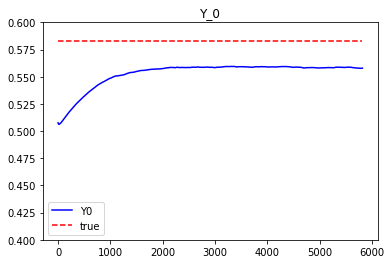

811th Iteration:
Y0 is 0.558192789554596, and true option price is 0.5828174603130847.
traing loss is 0.19634494185447693, test loss is 0.1200878769159317.
learning rate is 0.0010000000474974513, elapsed is 0.17539548873901367.
 
821th Iteration:
Y0 is 0.5582935810089111, and true option price is 0.5828174603130847.
traing loss is 0.20662306249141693, test loss is 0.11710001528263092.
learning rate is 0.0010000000474974513, elapsed is 0.09712576866149902.
 
831th Iteration:
Y0 is 0.558368980884552, and true option price is 0.5828174603130847.
traing loss is 0.15296843647956848, test loss is 0.12618130445480347.
learning rate is 0.0010000000474974513, elapsed is 0.10274696350097656.
 
841th Iteration:
Y0 is 0.5584465265274048, and true option price is 0.5828174603130847.
traing loss is 0.1579720824956894, test loss is 0.12837213277816772.
learning rate is 0.0010000000474974513, elapsed is 0.09994912147521973.
 
851th Iteration:
Y0 is 0.558547854423523, and true option price is 0.5828174

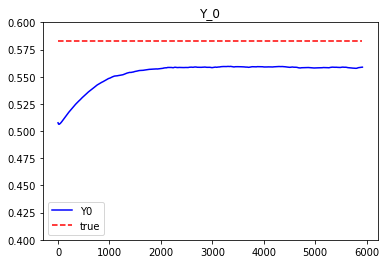

911th Iteration:
Y0 is 0.5588737726211548, and true option price is 0.5828174603130847.
traing loss is 0.17307087779045105, test loss is 0.12731565535068512.
learning rate is 0.0010000000474974513, elapsed is 0.17575359344482422.
 
921th Iteration:
Y0 is 0.5588806867599487, and true option price is 0.5828174603130847.
traing loss is 0.12724560499191284, test loss is 0.11819761991500854.
learning rate is 0.0010000000474974513, elapsed is 0.10524678230285645.
 
931th Iteration:
Y0 is 0.5589112043380737, and true option price is 0.5828174603130847.
traing loss is 0.1652676910161972, test loss is 0.12154580652713776.
learning rate is 0.0010000000474974513, elapsed is 0.11042428016662598.
 
941th Iteration:
Y0 is 0.5589609146118164, and true option price is 0.5828174603130847.
traing loss is 0.16572308540344238, test loss is 0.12422986328601837.
learning rate is 0.0010000000474974513, elapsed is 0.09975743293762207.
 
951th Iteration:
Y0 is 0.5590587258338928, and true option price is 0.582

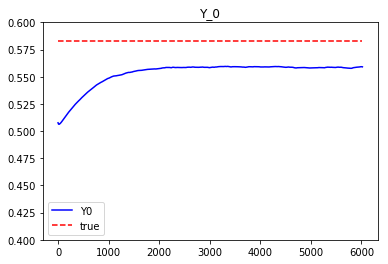

1011th Iteration:
Y0 is 0.5589932203292847, and true option price is 0.5828174603130847.
traing loss is 0.15535524487495422, test loss is 0.12448949366807938.
learning rate is 0.0010000000474974513, elapsed is 0.17854905128479004.
 
1021th Iteration:
Y0 is 0.5589343309402466, and true option price is 0.5828174603130847.
traing loss is 0.1407124102115631, test loss is 0.11681517213582993.
learning rate is 0.0010000000474974513, elapsed is 0.09826135635375977.
 
1031th Iteration:
Y0 is 0.5589287877082825, and true option price is 0.5828174603130847.
traing loss is 0.16943392157554626, test loss is 0.12727457284927368.
learning rate is 0.0010000000474974513, elapsed is 0.0992431640625.
 
1041th Iteration:
Y0 is 0.5589404106140137, and true option price is 0.5828174603130847.
traing loss is 0.18429341912269592, test loss is 0.12271423637866974.
learning rate is 0.0010000000474974513, elapsed is 0.09766817092895508.
 
1051th Iteration:
Y0 is 0.5589601993560791, and true option price is 0.58

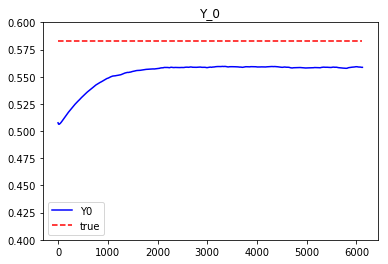

1111th Iteration:
Y0 is 0.5586546063423157, and true option price is 0.5828174603130847.
traing loss is 0.16323891282081604, test loss is 0.11943428218364716.
learning rate is 0.0010000000474974513, elapsed is 0.1791377067565918.
 
1121th Iteration:
Y0 is 0.5586476922035217, and true option price is 0.5828174603130847.
traing loss is 0.15969152748584747, test loss is 0.12040911614894867.
learning rate is 0.0010000000474974513, elapsed is 0.10303902626037598.
 
1131th Iteration:
Y0 is 0.5586493015289307, and true option price is 0.5828174603130847.
traing loss is 0.13109754025936127, test loss is 0.12118841707706451.
learning rate is 0.0010000000474974513, elapsed is 0.10231280326843262.
 
1141th Iteration:
Y0 is 0.5586622357368469, and true option price is 0.5828174603130847.
traing loss is 0.15407870709896088, test loss is 0.12131604552268982.
learning rate is 0.0010000000474974513, elapsed is 0.09854674339294434.
 
1151th Iteration:
Y0 is 0.5586767792701721, and true option price is 

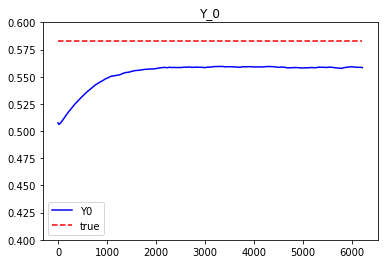

1211th Iteration:
Y0 is 0.5583456754684448, and true option price is 0.5828174603130847.
traing loss is 0.24020196497440338, test loss is 0.12222222238779068.
learning rate is 0.0010000000474974513, elapsed is 0.1810441017150879.
 
1221th Iteration:
Y0 is 0.5583657622337341, and true option price is 0.5828174603130847.
traing loss is 0.14256630837917328, test loss is 0.12440791726112366.
learning rate is 0.0010000000474974513, elapsed is 0.10065531730651855.
 
1231th Iteration:
Y0 is 0.5583611130714417, and true option price is 0.5828174603130847.
traing loss is 0.1644933968782425, test loss is 0.12591496109962463.
learning rate is 0.0010000000474974513, elapsed is 0.10088157653808594.
 
1241th Iteration:
Y0 is 0.5584302544593811, and true option price is 0.5828174603130847.
traing loss is 0.1792922168970108, test loss is 0.1261613517999649.
learning rate is 0.0010000000474974513, elapsed is 0.1008141040802002.
 
1251th Iteration:
Y0 is 0.5585306286811829, and true option price is 0.58

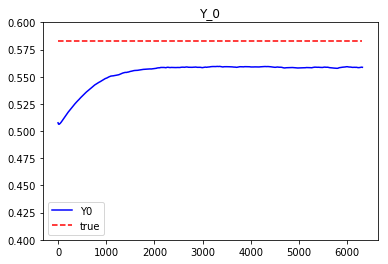

1311th Iteration:
Y0 is 0.5584601759910583, and true option price is 0.5828174603130847.
traing loss is 0.16042593121528625, test loss is 0.11939438432455063.
learning rate is 0.0010000000474974513, elapsed is 0.18184947967529297.
 
1321th Iteration:
Y0 is 0.5583832859992981, and true option price is 0.5828174603130847.
traing loss is 0.15015718340873718, test loss is 0.11843355000019073.
learning rate is 0.0010000000474974513, elapsed is 0.10343813896179199.
 
1331th Iteration:
Y0 is 0.5583836436271667, and true option price is 0.5828174603130847.
traing loss is 0.16349713504314423, test loss is 0.1169176995754242.
learning rate is 0.0010000000474974513, elapsed is 0.10372209548950195.
 
1341th Iteration:
Y0 is 0.5583838820457458, and true option price is 0.5828174603130847.
traing loss is 0.2062859982252121, test loss is 0.1183948963880539.
learning rate is 0.0010000000474974513, elapsed is 0.10075211524963379.
 
1351th Iteration:
Y0 is 0.5583540201187134, and true option price is 0.

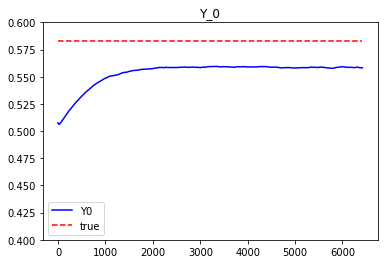

1411th Iteration:
Y0 is 0.5582679510116577, and true option price is 0.5828174603130847.
traing loss is 0.18375328183174133, test loss is 0.12185827642679214.
learning rate is 0.0010000000474974513, elapsed is 0.18650078773498535.
 
1421th Iteration:
Y0 is 0.5583223104476929, and true option price is 0.5828174603130847.
traing loss is 0.2049289345741272, test loss is 0.12082939594984055.
learning rate is 0.0010000000474974513, elapsed is 0.10957765579223633.
 
1431th Iteration:
Y0 is 0.5583456158638, and true option price is 0.5828174603130847.
traing loss is 0.1544753760099411, test loss is 0.11864694207906723.
learning rate is 0.0010000000474974513, elapsed is 0.1091928482055664.
 
1441th Iteration:
Y0 is 0.5583309531211853, and true option price is 0.5828174603130847.
traing loss is 0.17453747987747192, test loss is 0.12194313108921051.
learning rate is 0.0010000000474974513, elapsed is 0.10523390769958496.
 
1451th Iteration:
Y0 is 0.5583504438400269, and true option price is 0.582

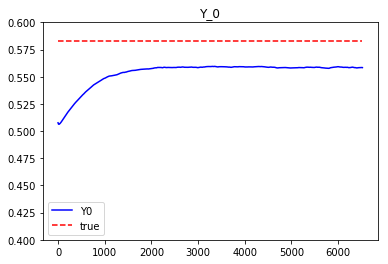

1511th Iteration:
Y0 is 0.558283805847168, and true option price is 0.5828174603130847.
traing loss is 0.12326011061668396, test loss is 0.12233142554759979.
learning rate is 0.0010000000474974513, elapsed is 0.17779850959777832.
 
1521th Iteration:
Y0 is 0.5582226514816284, and true option price is 0.5828174603130847.
traing loss is 0.2033666968345642, test loss is 0.12268912047147751.
learning rate is 0.0010000000474974513, elapsed is 0.10024261474609375.
 
1531th Iteration:
Y0 is 0.5582861304283142, and true option price is 0.5828174603130847.
traing loss is 0.15281689167022705, test loss is 0.13084882497787476.
learning rate is 0.0010000000474974513, elapsed is 0.10202431678771973.
 
1541th Iteration:
Y0 is 0.5583378672599792, and true option price is 0.5828174603130847.
traing loss is 0.20869669318199158, test loss is 0.12015766650438309.
learning rate is 0.0010000000474974513, elapsed is 0.10201334953308105.
 
1551th Iteration:
Y0 is 0.5583443641662598, and true option price is 0

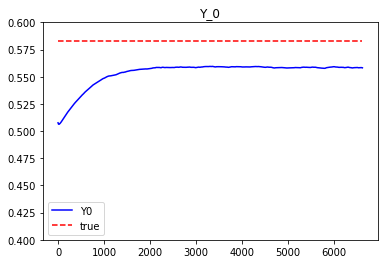

1611th Iteration:
Y0 is 0.5581912994384766, and true option price is 0.5828174603130847.
traing loss is 0.2505803406238556, test loss is 0.12689276039600372.
learning rate is 0.0010000000474974513, elapsed is 0.1750776767730713.
 
1621th Iteration:
Y0 is 0.5582224130630493, and true option price is 0.5828174603130847.
traing loss is 0.13382506370544434, test loss is 0.1217937096953392.
learning rate is 0.0010000000474974513, elapsed is 0.10152363777160645.
 
1631th Iteration:
Y0 is 0.5582724809646606, and true option price is 0.5828174603130847.
traing loss is 0.19119258224964142, test loss is 0.11783970147371292.
learning rate is 0.0010000000474974513, elapsed is 0.10201883316040039.
 
1641th Iteration:
Y0 is 0.5583891868591309, and true option price is 0.5828174603130847.
traing loss is 0.14116500318050385, test loss is 0.11468606442213058.
learning rate is 0.0010000000474974513, elapsed is 0.09973478317260742.
 
1651th Iteration:
Y0 is 0.558391809463501, and true option price is 0.5

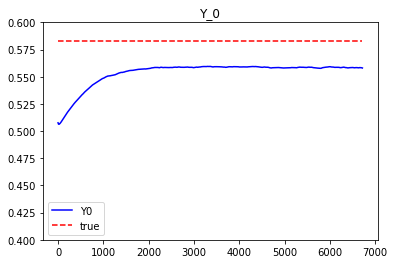

1711th Iteration:
Y0 is 0.5579624176025391, and true option price is 0.5828174603130847.
traing loss is 0.1463642716407776, test loss is 0.12232651561498642.
learning rate is 0.0010000000474974513, elapsed is 0.3289642333984375.
 
1721th Iteration:
Y0 is 0.5579434633255005, and true option price is 0.5828174603130847.
traing loss is 0.17124871909618378, test loss is 0.12211049348115921.
learning rate is 0.0010000000474974513, elapsed is 0.10748910903930664.
 
1731th Iteration:
Y0 is 0.5579173564910889, and true option price is 0.5828174603130847.
traing loss is 0.13948020339012146, test loss is 0.11876969039440155.
learning rate is 0.0010000000474974513, elapsed is 0.10521554946899414.
 
1741th Iteration:
Y0 is 0.5580068230628967, and true option price is 0.5828174603130847.
traing loss is 0.18174564838409424, test loss is 0.12383974343538284.
learning rate is 0.0010000000474974513, elapsed is 0.09941768646240234.
 
1751th Iteration:
Y0 is 0.5580383539199829, and true option price is 0

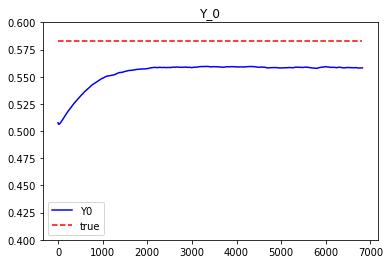

1811th Iteration:
Y0 is 0.5580881237983704, and true option price is 0.5828174603130847.
traing loss is 0.15071992576122284, test loss is 0.11800884455442429.
learning rate is 0.0010000000474974513, elapsed is 0.1834704875946045.
 
1821th Iteration:
Y0 is 0.5579376816749573, and true option price is 0.5828174603130847.
traing loss is 0.13629142940044403, test loss is 0.11818379163742065.
learning rate is 0.0010000000474974513, elapsed is 0.10006380081176758.
 
1831th Iteration:
Y0 is 0.5577975511550903, and true option price is 0.5828174603130847.
traing loss is 0.14232784509658813, test loss is 0.1272965669631958.
learning rate is 0.0010000000474974513, elapsed is 0.10372090339660645.
 
1841th Iteration:
Y0 is 0.5575770139694214, and true option price is 0.5828174603130847.
traing loss is 0.18269000947475433, test loss is 0.12283319234848022.
learning rate is 0.0010000000474974513, elapsed is 0.10164999961853027.
 
1851th Iteration:
Y0 is 0.5574386119842529, and true option price is 0

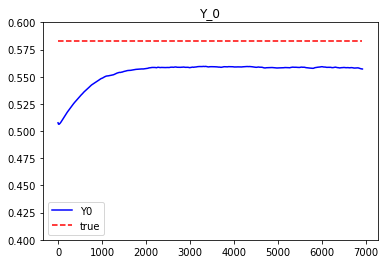

1911th Iteration:
Y0 is 0.5572031140327454, and true option price is 0.5828174603130847.
traing loss is 0.14082302153110504, test loss is 0.12322622537612915.
learning rate is 0.0010000000474974513, elapsed is 0.1817493438720703.
 
1921th Iteration:
Y0 is 0.5572880506515503, and true option price is 0.5828174603130847.
traing loss is 0.14656256139278412, test loss is 0.12655434012413025.
learning rate is 0.0010000000474974513, elapsed is 0.10040783882141113.
 
1931th Iteration:
Y0 is 0.5573397278785706, and true option price is 0.5828174603130847.
traing loss is 0.15592409670352936, test loss is 0.12612797319889069.
learning rate is 0.0010000000474974513, elapsed is 0.10060954093933105.
 
1941th Iteration:
Y0 is 0.557378351688385, and true option price is 0.5828174603130847.
traing loss is 0.18499664962291718, test loss is 0.11941323429346085.
learning rate is 0.0010000000474974513, elapsed is 0.1010284423828125.
 
1951th Iteration:
Y0 is 0.5573200583457947, and true option price is 0.

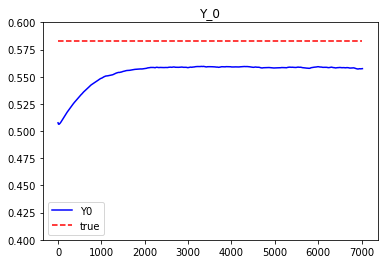

2011th Iteration:
Y0 is 0.557433009147644, and true option price is 0.5828174603130847.
traing loss is 0.13411864638328552, test loss is 0.11999163031578064.
learning rate is 0.0010000000474974513, elapsed is 0.18419146537780762.
 
2021th Iteration:
Y0 is 0.5574115514755249, and true option price is 0.5828174603130847.
traing loss is 0.18096376955509186, test loss is 0.11757151782512665.
learning rate is 0.0010000000474974513, elapsed is 0.10272645950317383.
 
2031th Iteration:
Y0 is 0.5573626160621643, and true option price is 0.5828174603130847.
traing loss is 0.15969984233379364, test loss is 0.12122450768947601.
learning rate is 0.0010000000474974513, elapsed is 0.0995948314666748.
 
2041th Iteration:
Y0 is 0.5572893619537354, and true option price is 0.5828174603130847.
traing loss is 0.16479483246803284, test loss is 0.12038801610469818.
learning rate is 0.0010000000474974513, elapsed is 0.10429692268371582.
 
2051th Iteration:
Y0 is 0.5571839809417725, and true option price is 0

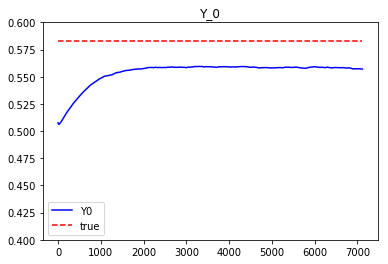

2111th Iteration:
Y0 is 0.5569812059402466, and true option price is 0.5828174603130847.
traing loss is 0.1921769678592682, test loss is 0.12383893877267838.
learning rate is 0.0010000000474974513, elapsed is 0.1779623031616211.
 
2121th Iteration:
Y0 is 0.5569862723350525, and true option price is 0.5828174603130847.
traing loss is 0.193406879901886, test loss is 0.1215849295258522.
learning rate is 0.0010000000474974513, elapsed is 0.10217022895812988.
 
2131th Iteration:
Y0 is 0.5569780468940735, and true option price is 0.5828174603130847.
traing loss is 0.1982664167881012, test loss is 0.12062402069568634.
learning rate is 0.0010000000474974513, elapsed is 0.10938358306884766.
 
2141th Iteration:
Y0 is 0.5568763613700867, and true option price is 0.5828174603130847.
traing loss is 0.16318772733211517, test loss is 0.12230219691991806.
learning rate is 0.0010000000474974513, elapsed is 0.10891222953796387.
 
2151th Iteration:
Y0 is 0.5568095445632935, and true option price is 0.582

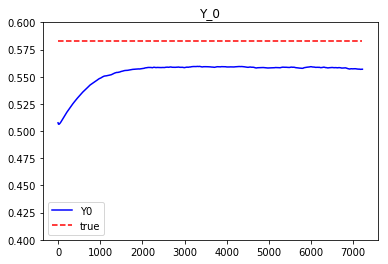

2211th Iteration:
Y0 is 0.55689537525177, and true option price is 0.5828174603130847.
traing loss is 0.13268212974071503, test loss is 0.11335558444261551.
learning rate is 0.0010000000474974513, elapsed is 0.18060564994812012.
 
2221th Iteration:
Y0 is 0.556904673576355, and true option price is 0.5828174603130847.
traing loss is 0.12422500550746918, test loss is 0.11525081098079681.
learning rate is 0.0010000000474974513, elapsed is 0.10722041130065918.
 
2231th Iteration:
Y0 is 0.556879997253418, and true option price is 0.5828174603130847.
traing loss is 0.156111940741539, test loss is 0.11968756467103958.
learning rate is 0.0010000000474974513, elapsed is 0.10354971885681152.
 
2241th Iteration:
Y0 is 0.5568135976791382, and true option price is 0.5828174603130847.
traing loss is 0.15407970547676086, test loss is 0.12008904665708542.
learning rate is 0.0010000000474974513, elapsed is 0.10827207565307617.
 
2251th Iteration:
Y0 is 0.5567459464073181, and true option price is 0.582

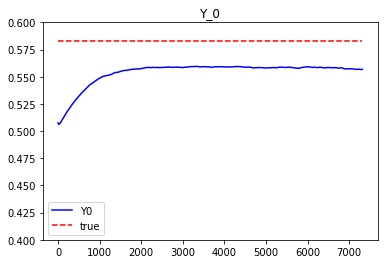

2311th Iteration:
Y0 is 0.5567141771316528, and true option price is 0.5828174603130847.
traing loss is 0.2017500102519989, test loss is 0.1224905326962471.
learning rate is 0.0010000000474974513, elapsed is 0.17854642868041992.
 
2321th Iteration:
Y0 is 0.5567377805709839, and true option price is 0.5828174603130847.
traing loss is 0.1763991117477417, test loss is 0.1163216158747673.
learning rate is 0.0010000000474974513, elapsed is 0.10146450996398926.
 
2331th Iteration:
Y0 is 0.55672287940979, and true option price is 0.5828174603130847.
traing loss is 0.17635293304920197, test loss is 0.1128697618842125.
learning rate is 0.0010000000474974513, elapsed is 0.10075926780700684.
 
2341th Iteration:
Y0 is 0.5566550493240356, and true option price is 0.5828174603130847.
traing loss is 0.14595679938793182, test loss is 0.11215092986822128.
learning rate is 0.0010000000474974513, elapsed is 0.10075807571411133.
 
2351th Iteration:
Y0 is 0.5566531419754028, and true option price is 0.5828

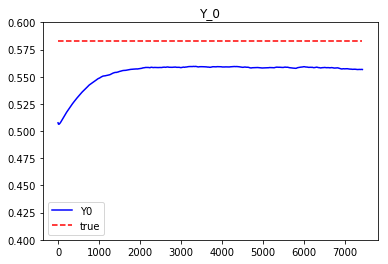

2411th Iteration:
Y0 is 0.5566188097000122, and true option price is 0.5828174603130847.
traing loss is 0.1322280764579773, test loss is 0.11682809889316559.
learning rate is 0.0010000000474974513, elapsed is 0.17551088333129883.
 
2421th Iteration:
Y0 is 0.5566258430480957, and true option price is 0.5828174603130847.
traing loss is 0.15310560166835785, test loss is 0.1163875013589859.
learning rate is 0.0010000000474974513, elapsed is 0.10042357444763184.
 
2431th Iteration:
Y0 is 0.5567260980606079, and true option price is 0.5828174603130847.
traing loss is 0.183624267578125, test loss is 0.12148689478635788.
learning rate is 0.0010000000474974513, elapsed is 0.09847354888916016.
 
2441th Iteration:
Y0 is 0.5567333102226257, and true option price is 0.5828174603130847.
traing loss is 0.13524138927459717, test loss is 0.11890585720539093.
learning rate is 0.0010000000474974513, elapsed is 0.09999632835388184.
 
2451th Iteration:
Y0 is 0.5567142367362976, and true option price is 0.5

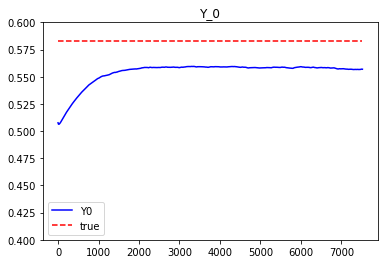

2511th Iteration:
Y0 is 0.5569641590118408, and true option price is 0.5828174603130847.
traing loss is 0.1356954127550125, test loss is 0.11917634308338165.
learning rate is 0.0010000000474974513, elapsed is 0.17753243446350098.
 
2521th Iteration:
Y0 is 0.5570082664489746, and true option price is 0.5828174603130847.
traing loss is 0.141551673412323, test loss is 0.11957316845655441.
learning rate is 0.0010000000474974513, elapsed is 0.10137104988098145.
 
2531th Iteration:
Y0 is 0.5570039749145508, and true option price is 0.5828174603130847.
traing loss is 0.14840389788150787, test loss is 0.12328273802995682.
learning rate is 0.0010000000474974513, elapsed is 0.10222983360290527.
 
2541th Iteration:
Y0 is 0.5570263862609863, and true option price is 0.5828174603130847.
traing loss is 0.1647348254919052, test loss is 0.11808186024427414.
learning rate is 0.0010000000474974513, elapsed is 0.10277438163757324.
 
2551th Iteration:
Y0 is 0.5571231842041016, and true option price is 0.5

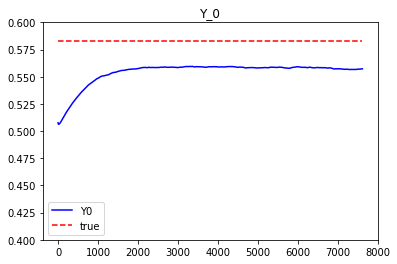

2611th Iteration:
Y0 is 0.5572854280471802, and true option price is 0.5828174603130847.
traing loss is 0.18851758539676666, test loss is 0.12697432935237885.
learning rate is 0.0010000000474974513, elapsed is 0.18865394592285156.
 
2621th Iteration:
Y0 is 0.5573668479919434, and true option price is 0.5828174603130847.
traing loss is 0.13545045256614685, test loss is 0.1202293187379837.
learning rate is 0.0010000000474974513, elapsed is 0.10327696800231934.
 
2631th Iteration:
Y0 is 0.5574095845222473, and true option price is 0.5828174603130847.
traing loss is 0.19578024744987488, test loss is 0.1137535572052002.
learning rate is 0.0010000000474974513, elapsed is 0.10466742515563965.
 
2641th Iteration:
Y0 is 0.5574044585227966, and true option price is 0.5828174603130847.
traing loss is 0.2308655083179474, test loss is 0.11685187369585037.
learning rate is 0.0010000000474974513, elapsed is 0.10658788681030273.
 
2651th Iteration:
Y0 is 0.5574402809143066, and true option price is 0.

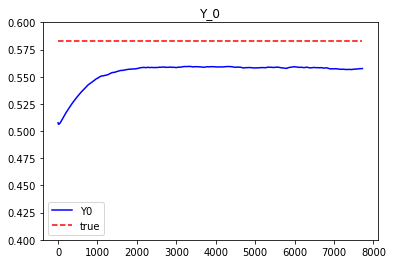

2711th Iteration:
Y0 is 0.557498037815094, and true option price is 0.5828174603130847.
traing loss is 0.15488487482070923, test loss is 0.11979688704013824.
learning rate is 0.0010000000474974513, elapsed is 0.17995882034301758.
 
2721th Iteration:
Y0 is 0.5574049949645996, and true option price is 0.5828174603130847.
traing loss is 0.12200417369604111, test loss is 0.1181190013885498.
learning rate is 0.0010000000474974513, elapsed is 0.10237431526184082.
 
2731th Iteration:
Y0 is 0.5573533773422241, and true option price is 0.5828174603130847.
traing loss is 0.14200444519519806, test loss is 0.1152699738740921.
learning rate is 0.0010000000474974513, elapsed is 0.10565614700317383.
 
2741th Iteration:
Y0 is 0.5573726296424866, and true option price is 0.5828174603130847.
traing loss is 0.14614759385585785, test loss is 0.11586381494998932.
learning rate is 0.0010000000474974513, elapsed is 0.10868525505065918.
 
2751th Iteration:
Y0 is 0.5573347210884094, and true option price is 0.

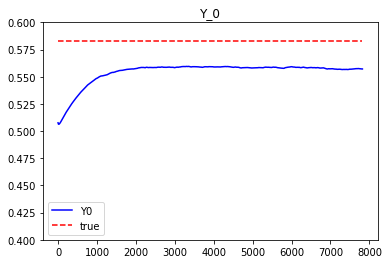

2811th Iteration:
Y0 is 0.5571188926696777, and true option price is 0.5828174603130847.
traing loss is 0.14600177109241486, test loss is 0.12087452411651611.
learning rate is 0.0010000000474974513, elapsed is 0.1905193328857422.
 
2821th Iteration:
Y0 is 0.5570580959320068, and true option price is 0.5828174603130847.
traing loss is 0.15559527277946472, test loss is 0.11903303861618042.
learning rate is 0.0010000000474974513, elapsed is 0.10561466217041016.
 
2831th Iteration:
Y0 is 0.5569820404052734, and true option price is 0.5828174603130847.
traing loss is 0.2217097282409668, test loss is 0.1171569973230362.
learning rate is 0.0010000000474974513, elapsed is 0.11138725280761719.
 
2841th Iteration:
Y0 is 0.5569828152656555, and true option price is 0.5828174603130847.
traing loss is 0.14968325197696686, test loss is 0.1150207370519638.
learning rate is 0.0010000000474974513, elapsed is 0.10318851470947266.
 
2851th Iteration:
Y0 is 0.5569508075714111, and true option price is 0.5

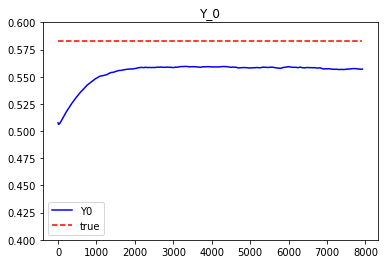

2911th Iteration:
Y0 is 0.5569679737091064, and true option price is 0.5828174603130847.
traing loss is 0.1584247201681137, test loss is 0.1167491003870964.
learning rate is 0.0010000000474974513, elapsed is 0.17951154708862305.
 
2921th Iteration:
Y0 is 0.5569621324539185, and true option price is 0.5828174603130847.
traing loss is 0.20235510170459747, test loss is 0.11670181155204773.
learning rate is 0.0010000000474974513, elapsed is 0.09843850135803223.
 
2931th Iteration:
Y0 is 0.5569274425506592, and true option price is 0.5828174603130847.
traing loss is 0.17450697720050812, test loss is 0.11270224303007126.
learning rate is 0.0010000000474974513, elapsed is 0.10091423988342285.
 
2941th Iteration:
Y0 is 0.5569788217544556, and true option price is 0.5828174603130847.
traing loss is 0.15499193966388702, test loss is 0.1120942085981369.
learning rate is 0.0010000000474974513, elapsed is 0.10174131393432617.
 
2951th Iteration:
Y0 is 0.556955099105835, and true option price is 0.5

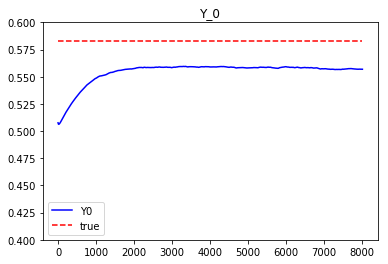

3011th Iteration:
Y0 is 0.5569649934768677, and true option price is 0.5828174603130847.
traing loss is 0.17130044102668762, test loss is 0.1193729117512703.
learning rate is 0.0010000000474974513, elapsed is 0.1879572868347168.
 
3021th Iteration:
Y0 is 0.5570778250694275, and true option price is 0.5828174603130847.
traing loss is 0.16242806613445282, test loss is 0.11674901843070984.
learning rate is 0.0010000000474974513, elapsed is 0.1095426082611084.
 
3031th Iteration:
Y0 is 0.5571228265762329, and true option price is 0.5828174603130847.
traing loss is 0.1510489583015442, test loss is 0.1157558262348175.
learning rate is 0.0010000000474974513, elapsed is 0.10573244094848633.
 
3041th Iteration:
Y0 is 0.557223916053772, and true option price is 0.5828174603130847.
traing loss is 0.1801937371492386, test loss is 0.12965737283229828.
learning rate is 0.0010000000474974513, elapsed is 0.09984707832336426.
 
3051th Iteration:
Y0 is 0.5573115348815918, and true option price is 0.5828

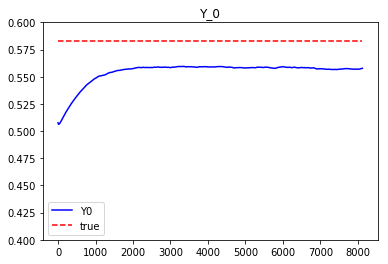

3111th Iteration:
Y0 is 0.5577143430709839, and true option price is 0.5828174603130847.
traing loss is 0.2357708066701889, test loss is 0.11674974858760834.
learning rate is 0.0010000000474974513, elapsed is 0.17691254615783691.
 
3121th Iteration:
Y0 is 0.5577858686447144, and true option price is 0.5828174603130847.
traing loss is 0.157278910279274, test loss is 0.11363054066896439.
learning rate is 0.0010000000474974513, elapsed is 0.10775518417358398.
 
3131th Iteration:
Y0 is 0.5577497482299805, and true option price is 0.5828174603130847.
traing loss is 0.15145409107208252, test loss is 0.11246682703495026.
learning rate is 0.0010000000474974513, elapsed is 0.11768507957458496.
 
3141th Iteration:
Y0 is 0.5575305223464966, and true option price is 0.5828174603130847.
traing loss is 0.1233096495270729, test loss is 0.11335764825344086.
learning rate is 0.0010000000474974513, elapsed is 0.11269998550415039.
 
3151th Iteration:
Y0 is 0.5573763847351074, and true option price is 0.5

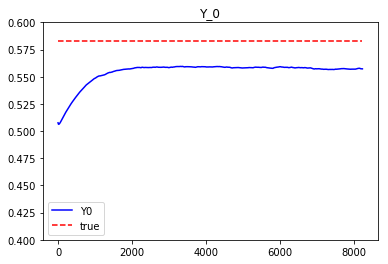

3211th Iteration:
Y0 is 0.5572685599327087, and true option price is 0.5828174603130847.
traing loss is 0.11575829237699509, test loss is 0.11897223442792892.
learning rate is 0.0010000000474974513, elapsed is 0.18291544914245605.
 
3221th Iteration:
Y0 is 0.5572630167007446, and true option price is 0.5828174603130847.
traing loss is 0.19824732840061188, test loss is 0.11822456121444702.
learning rate is 0.0010000000474974513, elapsed is 0.10420608520507812.
 
3231th Iteration:
Y0 is 0.55716872215271, and true option price is 0.5828174603130847.
traing loss is 0.14716100692749023, test loss is 0.11507121473550797.
learning rate is 0.0010000000474974513, elapsed is 0.10370516777038574.
 
3241th Iteration:
Y0 is 0.5569995045661926, and true option price is 0.5828174603130847.
traing loss is 0.18116803467273712, test loss is 0.11591409891843796.
learning rate is 0.0010000000474974513, elapsed is 0.11768507957458496.
 
3251th Iteration:
Y0 is 0.5568564534187317, and true option price is 0

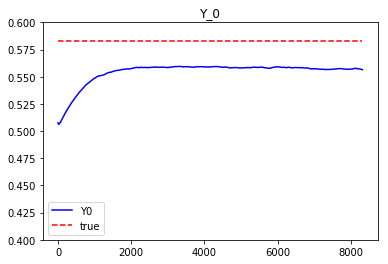

3311th Iteration:
Y0 is 0.5565095543861389, and true option price is 0.5828174603130847.
traing loss is 0.1562902331352234, test loss is 0.12513504922389984.
learning rate is 0.0010000000474974513, elapsed is 0.17593145370483398.
 
3321th Iteration:
Y0 is 0.5564723014831543, and true option price is 0.5828174603130847.
traing loss is 0.1382075846195221, test loss is 0.120945043861866.
learning rate is 0.0010000000474974513, elapsed is 0.09943914413452148.
 
3331th Iteration:
Y0 is 0.5564130544662476, and true option price is 0.5828174603130847.
traing loss is 0.12788832187652588, test loss is 0.1137075424194336.
learning rate is 0.0010000000474974513, elapsed is 0.10192036628723145.
 
3341th Iteration:
Y0 is 0.556390643119812, and true option price is 0.5828174603130847.
traing loss is 0.2638339698314667, test loss is 0.11311950534582138.
learning rate is 0.0010000000474974513, elapsed is 0.10015583038330078.
 
3351th Iteration:
Y0 is 0.5564500093460083, and true option price is 0.5828

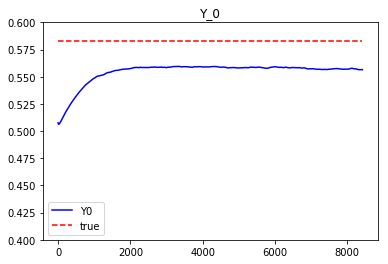

3411th Iteration:
Y0 is 0.5563480854034424, and true option price is 0.5828174603130847.
traing loss is 0.15866485238075256, test loss is 0.11121110618114471.
learning rate is 0.0010000000474974513, elapsed is 0.17156648635864258.
 
3421th Iteration:
Y0 is 0.5562461018562317, and true option price is 0.5828174603130847.
traing loss is 0.13833796977996826, test loss is 0.11371894925832748.
learning rate is 0.0010000000474974513, elapsed is 0.10265564918518066.
 
3431th Iteration:
Y0 is 0.5561119318008423, and true option price is 0.5828174603130847.
traing loss is 0.14200302958488464, test loss is 0.11602868884801865.
learning rate is 0.0010000000474974513, elapsed is 0.10339736938476562.
 
3441th Iteration:
Y0 is 0.5560451745986938, and true option price is 0.5828174603130847.
traing loss is 0.15417368710041046, test loss is 0.1276169717311859.
learning rate is 0.0010000000474974513, elapsed is 0.10120892524719238.
 
3451th Iteration:
Y0 is 0.5561522245407104, and true option price is 

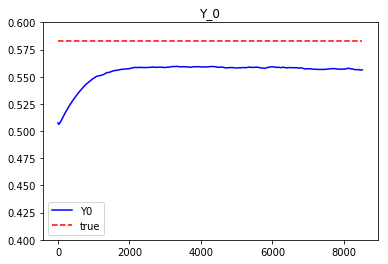

3511th Iteration:
Y0 is 0.5563894510269165, and true option price is 0.5828174603130847.
traing loss is 0.14842480421066284, test loss is 0.12662553787231445.
learning rate is 0.0010000000474974513, elapsed is 0.17081832885742188.
 
3521th Iteration:
Y0 is 0.556394636631012, and true option price is 0.5828174603130847.
traing loss is 0.13875629007816315, test loss is 0.11666985601186752.
learning rate is 0.0010000000474974513, elapsed is 0.10129737854003906.
 
3531th Iteration:
Y0 is 0.5565065741539001, and true option price is 0.5828174603130847.
traing loss is 0.1537061184644699, test loss is 0.11496942490339279.
learning rate is 0.0010000000474974513, elapsed is 0.10106444358825684.
 
3541th Iteration:
Y0 is 0.5566014647483826, and true option price is 0.5828174603130847.
traing loss is 0.16137942671775818, test loss is 0.12177150696516037.
learning rate is 0.0010000000474974513, elapsed is 0.10274767875671387.
 
3551th Iteration:
Y0 is 0.5565986037254333, and true option price is 0

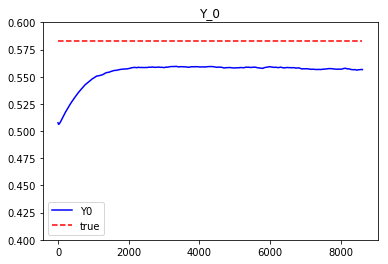

3611th Iteration:
Y0 is 0.5565427541732788, and true option price is 0.5828174603130847.
traing loss is 0.13223698735237122, test loss is 0.112006776034832.
learning rate is 0.0010000000474974513, elapsed is 0.18187999725341797.
 
3621th Iteration:
Y0 is 0.556526243686676, and true option price is 0.5828174603130847.
traing loss is 0.1829540729522705, test loss is 0.11147218197584152.
learning rate is 0.0010000000474974513, elapsed is 0.10642004013061523.
 
3631th Iteration:
Y0 is 0.5564813017845154, and true option price is 0.5828174603130847.
traing loss is 0.2175094038248062, test loss is 0.11427517980337143.
learning rate is 0.0010000000474974513, elapsed is 0.10974860191345215.
 
3641th Iteration:
Y0 is 0.5564695000648499, and true option price is 0.5828174603130847.
traing loss is 0.16221030056476593, test loss is 0.11582757532596588.
learning rate is 0.0010000000474974513, elapsed is 0.11720681190490723.
 
3651th Iteration:
Y0 is 0.5564799308776855, and true option price is 0.58

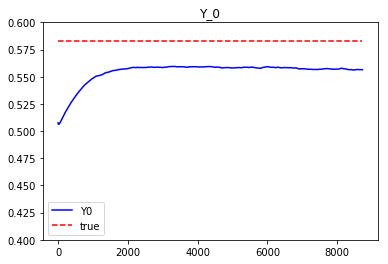

3711th Iteration:
Y0 is 0.5564579963684082, and true option price is 0.5828174603130847.
traing loss is 0.1474490463733673, test loss is 0.11793657392263412.
learning rate is 0.0010000000474974513, elapsed is 0.17493247985839844.
 
3721th Iteration:
Y0 is 0.5564755797386169, and true option price is 0.5828174603130847.
traing loss is 0.11681102216243744, test loss is 0.11496013402938843.
learning rate is 0.0010000000474974513, elapsed is 0.10646367073059082.
 
3731th Iteration:
Y0 is 0.5564773082733154, and true option price is 0.5828174603130847.
traing loss is 0.1297467201948166, test loss is 0.11994108557701111.
learning rate is 0.0010000000474974513, elapsed is 0.10970616340637207.
 
3741th Iteration:
Y0 is 0.556472659111023, and true option price is 0.5828174603130847.
traing loss is 0.14543157815933228, test loss is 0.1188649907708168.
learning rate is 0.0010000000474974513, elapsed is 0.10373640060424805.
 
3751th Iteration:
Y0 is 0.5565788149833679, and true option price is 0.5

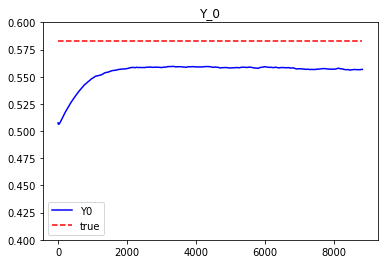

3811th Iteration:
Y0 is 0.5567173957824707, and true option price is 0.5828174603130847.
traing loss is 0.16991890966892242, test loss is 0.11027494072914124.
learning rate is 0.0010000000474974513, elapsed is 0.17542481422424316.
 
3821th Iteration:
Y0 is 0.5567811131477356, and true option price is 0.5828174603130847.
traing loss is 0.2050866186618805, test loss is 0.11812825500965118.
learning rate is 0.0010000000474974513, elapsed is 0.09981322288513184.
 
3831th Iteration:
Y0 is 0.5568652749061584, and true option price is 0.5828174603130847.
traing loss is 0.13961370289325714, test loss is 0.11527613550424576.
learning rate is 0.0010000000474974513, elapsed is 0.1024484634399414.
 
3841th Iteration:
Y0 is 0.5568096041679382, and true option price is 0.5828174603130847.
traing loss is 0.14939068257808685, test loss is 0.11362232267856598.
learning rate is 0.0010000000474974513, elapsed is 0.0995934009552002.
 
3851th Iteration:
Y0 is 0.556717574596405, and true option price is 0.5

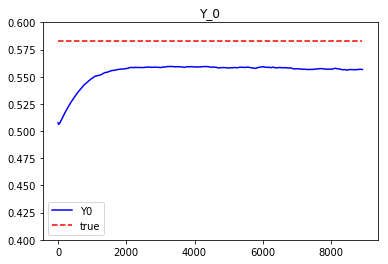

3911th Iteration:
Y0 is 0.5565968155860901, and true option price is 0.5828174603130847.
traing loss is 0.14840374886989594, test loss is 0.11220251768827438.
learning rate is 0.0010000000474974513, elapsed is 0.17433881759643555.
 
3921th Iteration:
Y0 is 0.5564891695976257, and true option price is 0.5828174603130847.
traing loss is 0.1691189408302307, test loss is 0.11047131568193436.
learning rate is 0.0010000000474974513, elapsed is 0.10348629951477051.
 
3931th Iteration:
Y0 is 0.556392252445221, and true option price is 0.5828174603130847.
traing loss is 0.17852474749088287, test loss is 0.11951083689928055.
learning rate is 0.0010000000474974513, elapsed is 0.1023416519165039.
 
3941th Iteration:
Y0 is 0.5563339591026306, and true option price is 0.5828174603130847.
traing loss is 0.1441439837217331, test loss is 0.11852934211492538.
learning rate is 0.0010000000474974513, elapsed is 0.10146021842956543.
 
3951th Iteration:
Y0 is 0.556317925453186, and true option price is 0.58

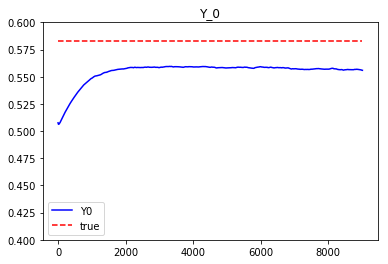

4011th Iteration:
Y0 is 0.5559262633323669, and true option price is 0.5828174603130847.
traing loss is 0.1809263676404953, test loss is 0.11164850741624832.
learning rate is 0.0010000000474974513, elapsed is 0.16990280151367188.
 
4021th Iteration:
Y0 is 0.5559651851654053, and true option price is 0.5828174603130847.
traing loss is 0.16749897599220276, test loss is 0.11777278035879135.
learning rate is 0.0010000000474974513, elapsed is 0.10280585289001465.
 
4031th Iteration:
Y0 is 0.5559741258621216, and true option price is 0.5828174603130847.
traing loss is 0.1655953824520111, test loss is 0.11909335851669312.
learning rate is 0.0010000000474974513, elapsed is 0.10073328018188477.
 
4041th Iteration:
Y0 is 0.5559108853340149, and true option price is 0.5828174603130847.
traing loss is 0.19422806799411774, test loss is 0.11939361691474915.
learning rate is 0.0010000000474974513, elapsed is 0.09934234619140625.
 
4051th Iteration:
Y0 is 0.5558842420578003, and true option price is 0

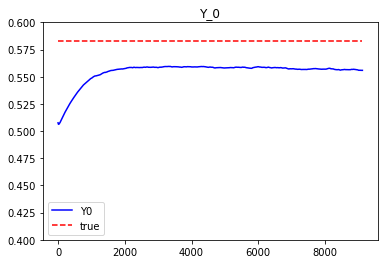

4111th Iteration:
Y0 is 0.5559130311012268, and true option price is 0.5828174603130847.
traing loss is 0.1750078797340393, test loss is 0.11935652047395706.
learning rate is 0.0010000000474974513, elapsed is 0.1713087558746338.
 
4121th Iteration:
Y0 is 0.555890679359436, and true option price is 0.5828174603130847.
traing loss is 0.17108209431171417, test loss is 0.11282917112112045.
learning rate is 0.0010000000474974513, elapsed is 0.10466527938842773.
 
4131th Iteration:
Y0 is 0.5559496879577637, and true option price is 0.5828174603130847.
traing loss is 0.12237697094678879, test loss is 0.11443028599023819.
learning rate is 0.0010000000474974513, elapsed is 0.1047217845916748.
 
4141th Iteration:
Y0 is 0.5560405254364014, and true option price is 0.5828174603130847.
traing loss is 0.14006784558296204, test loss is 0.11739037930965424.
learning rate is 0.0010000000474974513, elapsed is 0.10671353340148926.
 
4151th Iteration:
Y0 is 0.5560926795005798, and true option price is 0.5

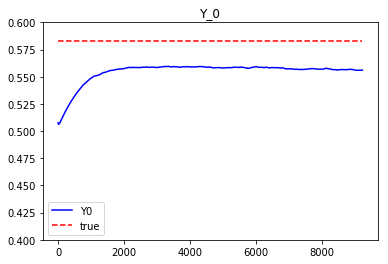

4211th Iteration:
Y0 is 0.5561395883560181, and true option price is 0.5828174603130847.
traing loss is 0.17518851161003113, test loss is 0.11857438087463379.
learning rate is 0.0010000000474974513, elapsed is 0.17253828048706055.
 
4221th Iteration:
Y0 is 0.5561856031417847, and true option price is 0.5828174603130847.
traing loss is 0.1681569665670395, test loss is 0.11390191316604614.
learning rate is 0.0010000000474974513, elapsed is 0.10162973403930664.
 
4231th Iteration:
Y0 is 0.5562098026275635, and true option price is 0.5828174603130847.
traing loss is 0.18311211466789246, test loss is 0.1150226891040802.
learning rate is 0.0010000000474974513, elapsed is 0.10870909690856934.
 
4241th Iteration:
Y0 is 0.5562105774879456, and true option price is 0.5828174603130847.
traing loss is 0.13546398282051086, test loss is 0.11906363070011139.
learning rate is 0.0010000000474974513, elapsed is 0.10870933532714844.
 
4251th Iteration:
Y0 is 0.5562052130699158, and true option price is 0

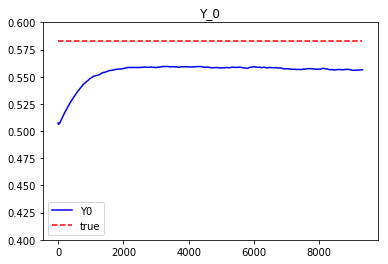

4311th Iteration:
Y0 is 0.5564528107643127, and true option price is 0.5828174603130847.
traing loss is 0.19396033883094788, test loss is 0.11399676650762558.
learning rate is 0.0010000000474974513, elapsed is 0.1850581169128418.
 
4321th Iteration:
Y0 is 0.5563852787017822, and true option price is 0.5828174603130847.
traing loss is 0.12795154750347137, test loss is 0.11401105672121048.
learning rate is 0.0010000000474974513, elapsed is 0.11028504371643066.
 
4331th Iteration:
Y0 is 0.5562453269958496, and true option price is 0.5828174603130847.
traing loss is 0.15617693960666656, test loss is 0.11216942965984344.
learning rate is 0.0010000000474974513, elapsed is 0.10870933532714844.
 
4341th Iteration:
Y0 is 0.5561057329177856, and true option price is 0.5828174603130847.
traing loss is 0.12068533152341843, test loss is 0.11292378604412079.
learning rate is 0.0010000000474974513, elapsed is 0.10594439506530762.
 
4351th Iteration:
Y0 is 0.5560253858566284, and true option price is 

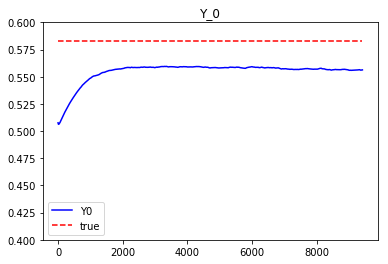

4411th Iteration:
Y0 is 0.5562871098518372, and true option price is 0.5828174603130847.
traing loss is 0.13513122498989105, test loss is 0.12094775587320328.
learning rate is 0.0010000000474974513, elapsed is 0.17620539665222168.
 
4421th Iteration:
Y0 is 0.556288480758667, and true option price is 0.5828174603130847.
traing loss is 0.12491578608751297, test loss is 0.11772333830595016.
learning rate is 0.0010000000474974513, elapsed is 0.10382390022277832.
 
4431th Iteration:
Y0 is 0.5562825798988342, and true option price is 0.5828174603130847.
traing loss is 0.12200836092233658, test loss is 0.11692412197589874.
learning rate is 0.0010000000474974513, elapsed is 0.10431838035583496.
 
4441th Iteration:
Y0 is 0.5562406182289124, and true option price is 0.5828174603130847.
traing loss is 0.18869714438915253, test loss is 0.11484471708536148.
learning rate is 0.0010000000474974513, elapsed is 0.1077113151550293.
 
4451th Iteration:
Y0 is 0.5562360882759094, and true option price is 0

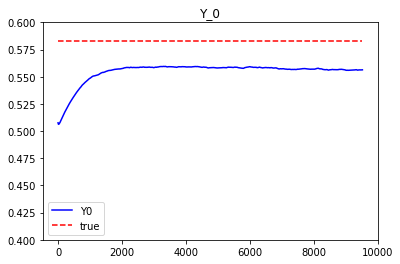

4511th Iteration:
Y0 is 0.5563219785690308, and true option price is 0.5828174603130847.
traing loss is 0.1457497626543045, test loss is 0.12315374612808228.
learning rate is 0.0010000000474974513, elapsed is 0.17351102828979492.
 
4521th Iteration:
Y0 is 0.5562823414802551, and true option price is 0.5828174603130847.
traing loss is 0.15028993785381317, test loss is 0.12334492802619934.
learning rate is 0.0010000000474974513, elapsed is 0.10418343544006348.
 
4531th Iteration:
Y0 is 0.556267499923706, and true option price is 0.5828174603130847.
traing loss is 0.1589217483997345, test loss is 0.1202828660607338.
learning rate is 0.0010000000474974513, elapsed is 0.1077117919921875.
 
4541th Iteration:
Y0 is 0.5562779903411865, and true option price is 0.5828174603130847.
traing loss is 0.17426708340644836, test loss is 0.1180337592959404.
learning rate is 0.0010000000474974513, elapsed is 0.10272431373596191.
 
4551th Iteration:
Y0 is 0.556312084197998, and true option price is 0.5828

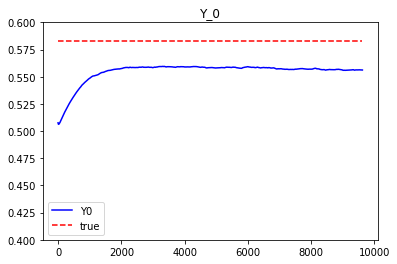

4611th Iteration:
Y0 is 0.556086540222168, and true option price is 0.5828174603130847.
traing loss is 0.23377133905887604, test loss is 0.11275245994329453.
learning rate is 0.0010000000474974513, elapsed is 0.17875051498413086.
 
4621th Iteration:
Y0 is 0.5559905171394348, and true option price is 0.5828174603130847.
traing loss is 0.12395890802145004, test loss is 0.11368299275636673.
learning rate is 0.0010000000474974513, elapsed is 0.10468363761901855.
 
4631th Iteration:
Y0 is 0.555975079536438, and true option price is 0.5828174603130847.
traing loss is 0.11865188926458359, test loss is 0.11312466114759445.
learning rate is 0.0010000000474974513, elapsed is 0.10527539253234863.
 
4641th Iteration:
Y0 is 0.5559625029563904, and true option price is 0.5828174603130847.
traing loss is 0.18697543442249298, test loss is 0.11310788989067078.
learning rate is 0.0010000000474974513, elapsed is 0.10175752639770508.
 
4651th Iteration:
Y0 is 0.555982768535614, and true option price is 0.

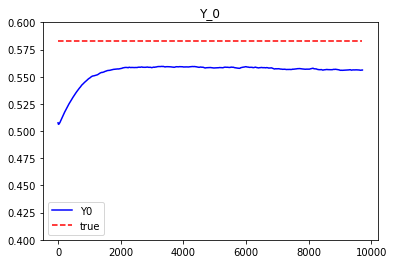

4711th Iteration:
Y0 is 0.5561822056770325, and true option price is 0.5828174603130847.
traing loss is 0.218924418091774, test loss is 0.11568082869052887.
learning rate is 0.0010000000474974513, elapsed is 0.1715245246887207.
 
4721th Iteration:
Y0 is 0.5561147332191467, and true option price is 0.5828174603130847.
traing loss is 0.1763133704662323, test loss is 0.11496895551681519.
learning rate is 0.0010000000474974513, elapsed is 0.10063886642456055.
 
4731th Iteration:
Y0 is 0.5560678839683533, and true option price is 0.5828174603130847.
traing loss is 0.14221718907356262, test loss is 0.11623799055814743.
learning rate is 0.0010000000474974513, elapsed is 0.09868144989013672.
 
4741th Iteration:
Y0 is 0.5560872554779053, and true option price is 0.5828174603130847.
traing loss is 0.1483374834060669, test loss is 0.11644136160612106.
learning rate is 0.0010000000474974513, elapsed is 0.10065054893493652.
 
4751th Iteration:
Y0 is 0.5561385154724121, and true option price is 0.58

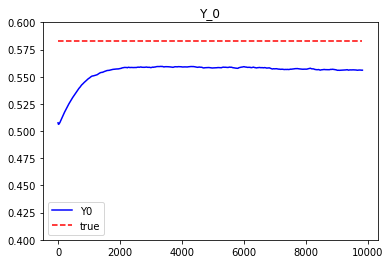

4811th Iteration:
Y0 is 0.5560415983200073, and true option price is 0.5828174603130847.
traing loss is 0.19085314869880676, test loss is 0.11311282962560654.
learning rate is 0.0010000000474974513, elapsed is 0.17353606224060059.
 
4821th Iteration:
Y0 is 0.5560375452041626, and true option price is 0.5828174603130847.
traing loss is 0.1769828051328659, test loss is 0.11499112099409103.
learning rate is 0.0010000000474974513, elapsed is 0.1027534008026123.
 
4831th Iteration:
Y0 is 0.5561391115188599, and true option price is 0.5828174603130847.
traing loss is 0.1403152346611023, test loss is 0.11950187385082245.
learning rate is 0.0010000000474974513, elapsed is 0.10310649871826172.
 
4841th Iteration:
Y0 is 0.5561721324920654, and true option price is 0.5828174603130847.
traing loss is 0.20377328991889954, test loss is 0.12180370092391968.
learning rate is 0.0010000000474974513, elapsed is 0.10266828536987305.
 
4851th Iteration:
Y0 is 0.556192934513092, and true option price is 0.5

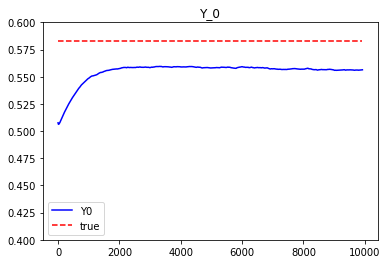

4911th Iteration:
Y0 is 0.5563857555389404, and true option price is 0.5828174603130847.
traing loss is 0.17039763927459717, test loss is 0.11596184968948364.
learning rate is 0.0010000000474974513, elapsed is 0.17444801330566406.
 
4921th Iteration:
Y0 is 0.5564173460006714, and true option price is 0.5828174603130847.
traing loss is 0.12409709393978119, test loss is 0.11789869517087936.
learning rate is 0.0010000000474974513, elapsed is 0.1097254753112793.
 
4931th Iteration:
Y0 is 0.556393563747406, and true option price is 0.5828174603130847.
traing loss is 0.15996241569519043, test loss is 0.11902212351560593.
learning rate is 0.0010000000474974513, elapsed is 0.11185598373413086.
 
4941th Iteration:
Y0 is 0.5563462972640991, and true option price is 0.5828174603130847.
traing loss is 0.17800121009349823, test loss is 0.1226571574807167.
learning rate is 0.0010000000474974513, elapsed is 0.1049954891204834.
 
4951th Iteration:
Y0 is 0.5562710165977478, and true option price is 0.5

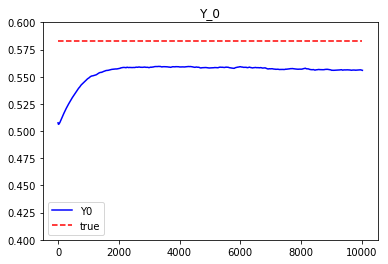

In [23]:
start_time = ttt.time()

for it in range(Epoch):
    index = np.random.randint(W_segs_feed.shape[0], size = batch_size)
    #shuffle
    feed_dict = {signature: signature_feed[index,:], 
                 BM: W_segs_feed[index,:], 
                 terminal: terminal_feed[index,:]}
    sess.run(train_op, feed_dict)

    if (it % 10 == 0):
        elapsed = ttt.time() - start_time
        print("{}th Iteration:".format(it+1))
        loss_value = sess.run(loss, feed_dict)
        lr = sess.run(learning_rate)
        loss_test = sess.run(loss, test_dict)
        Y_test, Z_test = sess.run([all_Y, all_Z], test_dict)
        print("Y0 is {}, and true option price is {}.".format(np.mean(Y_test[:, 0]), true))
        print("traing loss is {}, test loss is {}.".format(loss_value, loss_test))
        print("learning rate is {}, elapsed is {}.".format(lr, elapsed))
        print(" ")

        train_loss_list.append(loss_value)
        test_loss_list.append(loss_test)     
        Y0_list.append(np.mean(Y_test[:, 0]))
        start_time = ttt.time()

        
    if (it % 100 == 0):
        num_epoches = len(train_loss_list)
        x_axis_epoches = np.linspace(0, num_epoches*10, num_epoches)
        # plot price at time 0
        plt.plot(x_axis_epoches, Y0_list, 'b-', label = "Y0")
        plt.plot(x_axis_epoches, (true)*np.ones(num_epoches), 'r--', label = "true")
        plt.legend()
        plt.ylim([0.4, 0.6])
        plt.title("Y_0")
        plt.show()


In [22]:
np.save("Y0_lookback_sig_{}_from_{}.npy".format(segs, steps), Y0_list)
np.save("Yt_lookback_sig_{}_from_{}.npy".format(segs, steps), Y_test)